In [39]:
# Install packages
! pip install opencv-python
! pip install nibabel
! pip install scipy
! pip install SimpleITK

In [57]:
### Goal: Align pre and post ct, fluoro images. Output aligned landmark coordinates DBS_bt2
# Inputs: pre and post ct, fluoro images. pins_ct coordinates, fluoro_coordinates
# Outputs: Aligned coordinates between fluoro and ct

# Steps for alignment: 
# 1. Define example landmark coordinates
# 2. Load fluoro and pre/post ct, check pixel sizes
# 3. Project ct to 2D-ask Milos and look at group's prior code
# 4. Alignment formula --> try manually aligning, see what steps you take, and conver that into a formula. 
# 5. Test alignment scheme on different patients.
# 6. See if the formula works for aligning the landmarks correctly. If not, work on algorithm for the landmark coordinates. 

### Import dependencies
import cv2
from utils import rotate, create_video
from PIL import Image
import numpy as np
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import matplotlib.pyplot as plt
import os
import math
import SimpleITK as sitk
import imageio

In [62]:
### Load prect, postct, and fluoroscopy images/data

#read pre op CT
prect = nib.load('/Users/Micah Vinet/OneDrive/Documents/Visual Studio Code/ECoG/DBS_bT20/rpreop_ct.nii')
prect_data = np.nan_to_num(np.array(prect.get_fdata()))

#read post op CT
postct = nib.load('/Users/Micah Vinet/OneDrive/Documents/Visual Studio Code/ECoG/DBS_bT20/rpostop_ct.nii')
postct_data = np.nan_to_num(np.array(postct.get_fdata()))
postct_sitk_img = sitk.GetImageFromArray(postct_data)

#read fluoro
fluoro = imageio.imread('/Users/Micah Vinet/OneDrive/Documents/Visual Studio Code/ECoG/DBS_bT20/fluoro20.tif')
fluoro = cv2.cvtColor(fluoro, cv2.COLOR_BGR2GRAY)

In [63]:
### Display prect image dimensions
print(prect.shape)

(256, 256, 192)


In [72]:
### Display postct image dimensions
print(postct.shape)

(256, 256, 192)


(1222, 1527)


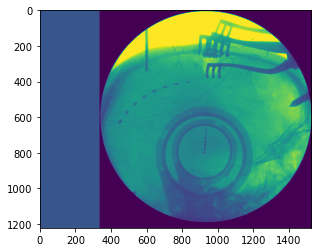

In [31]:
### Display fluoro image and dimensions
print(fluoro.shape)
plt.imshow(fluoro)

In [36]:
# Define example landmark coordinates
landmark = np.array([50,150])

(150, 150)


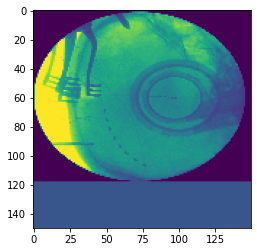

In [34]:
### resize, rotate, and display fluoro image
fluoro = cv2.resize(fluoro,(150,150))
fluoro = rotate(fluoro, 90)

print(fluoro.shape)
plt.imshow(fluoro)

In [90]:
#Adapted from previous group code
def get_middle_half(postct):
    # Define saggital slices
    saggital_slices = postct.shape[2]
    first_quarter = int(saggital_slices * 1/4)
    third_quarter = int(saggital_slices * 3/4)
    # Use middle 1/2 of slices in sagittal (z) direction
    middle_half = postct_data[:, :, np.s_[first_quarter:third_quarter]]
    middle_half_num = middle_half.shape[2]
        
    return(middle_half, middle_half_num)

In [92]:
#Adapted from previous group code
def xySlope(start_crd, end_crd, z):
    xSlope = (end_crd[0] - start_crd[0]) / z
    ySlope = (end_crd[1] - start_crd[1]) / z
        
    return(xSlope, ySlope)

In [95]:
#Adapted from previous group code
def endPointTraverse(xPos, yPos, xslope, yslope, numZ, ct_middle_array, ct_middle_num):
    if numZ == 0:
        return 0
    newX = xPos + xslope
    newY = yPos + yslope

# Get updated value through traversing next slice
    current_pos = ct_middle_array[math.floor(yPos)][math.floor(xPos)][ct_middle_num - numZ]
    traversed_value = current_pos + endPointTraverse(newX, newY, xslope, yslope, numZ - 1, ct_middle_array, ct_middle_num)

    return(traversed_value)

In [96]:
#Adapted from previous group code
def createNewImage(start_pos, distance_first, case_ct_path):
    ct_middle_array, ct_middle_num = get_middle_half(case_ct_path)
    numY, numX, numZ = ct_middle_array.shape
    new2DMatrix = np.array([])

    for y in range(numY):
        newRow = np.array([])
        
    for x in range(numX):
        xSlope, ySlope = xySlope(start_pos, (x, y), distance_first + numZ)
        startXAtFirstSlice = start_pos[0] + (xSlope * distance_first)
        startYAtFirstSlice = start_pos[1] + (ySlope * distance_first)
        
        traverse_results = endPointTraverse(startXAtFirstSlice, startYAtFirstSlice, xSlope, ySlope, numZ, ct_middle_array, ct_middle_num)
        newRow = np.append(newRow, [traverse_results])
    
        #add row to matrix
    if(new2DMatrix.size == 0):
        new2DMatrix = np.array([newRow])
    else:
        new2DMatrix = np.append(new2DMatrix, [newRow], axis = 0)

  # Rotate projected_2D image array by 90 degrees clockwise
    rot2d_Matrix = np.rot90(new2DMatrix, axes = (1,0))
        
    return(rot2d_Matrix)

(256, 1)


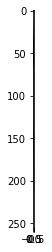

In [97]:
#Define projection parameters
start_position = (128,128)
distFromImg = 256 * 1.5

#Project and rotate postop ct image
rotated_ct_matrix = createNewImage(start_position, distFromImg, postct)

#Display projected postop ct image and dimensions
print(rotated_ct_matrix.shape)
plt.imshow(rotated_ct_matrix,cmap = 'gray')

In [98]:
#Homography and procrustes https://codeshare.io/wnWmdx
#https://mne.tools/stable/auto_examples/visualization/3d_to_2d.html
shift_down = 296
shift_right = 226

fluoro_v = np.vstack((np.ones((shift_down,)+fluoro.shape[1:], dtype=fluoro.dtype), fluoro))
fluoro_vh = np.hstack((np.ones(fluoro_v.shape[:1]+(shift_right,), dtype=fluoro_v.dtype), fluoro_v))

#Output coordinates
coords = np.array([[149.0, 77.0],[143.0, 75.0],[137.0, 76.0],[132.0, 77.0],[127.0, 78.0]])


In [87]:
%whos

Variable            Type           Data/Info
--------------------------------------------
Image               module         <module 'PIL.Image' from <...>packages\\PIL\\Image.py'>
coords              ndarray        5x2: 10 elems, type `float64`, 80 bytes
createNewImage      function       <function createNewImage at 0x000001BDB012C1F0>
create_video        function       <function create_video at 0x000001BDAAC7F430>
cv2                 module         <module 'cv2' from 'C:\\P<...>kages\\cv2\\__init__.py'>
distFromImg         float          384.0
endPointTraverse    function       <function endPointTraverse at 0x000001BDB4B24F70>
first_quarter       int            48
fluoro              ndarray        1222x1527: 1865994 elems, type `uint8`, 1865994 bytes (1.779550552368164 Mb)
fluoro_v            ndarray        1518x1527: 2317986 elems, type `uint8`, 2317986 bytes (2.210603713989258 Mb)
fluoro_vh           ndarray        1518x1753: 2661054 elems, type `uint8`, 2661054 bytes (2.537778854